In [1]:
from importlib import reload
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score,TimeSeriesSplit
from imblearn.under_sampling import CondensedNearestNeighbour
import xgboost as xgb
import joblib
import pickle
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sma
import statsmodels.stats.outliers_influence  as smo
from scipy.stats import uniform, randint,probplot,shapiro
import model_mngr as modmgr
import split_merge as sm
import add_indicators as indic
import balance
import pandas as pd
import numpy as np
import random as rd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from boruta import BorutaPy
import maria_import_export as maria
reload(maria)
reload(indic)
reload(sm)
reload(modmgr)
reload(balance)


<module 'balance' from 'C:\\Projets\\MarketDataEnrichment\\dataset_mngr\\balance.py'>

Load data for CW8 ETF from Maria
Add indicators and labels and save the dataset on disk

In [2]:
PATH_DATA = "../../../Data/DTS_FULL/"
PATH_MODEL = "../../../Data/Models/"
PATH_RES = "../../../Data/Res/"
symb = "CW8"
dts_name = "DCA_CLOSE_1D_V1"
rnd_key = int(maria.get_conf("RANDOM_KEY"))
df = pd.DataFrame()
if "con" in locals():
    maria.close_connection(con)
con = maria.get_connection()
df = maria.get_candles_to_df(con=con, symbol=symb, only_close=True)
df = indic.add_indicators_to_df(con=con, df_in=df, dts_name=dts_name)
df.sort_index(inplace=True)
#df.round(5).to_csv(PATH_DATA+dts_name+"_full.zip", sep=",")


Clean the dataset droping useless features
Split the dataset by labels, train, val, conf part

In [3]:
df = indic.drop_indicators_by_type(
    con=con, df_in=df, dts_name=dts_name, symbol=symb, ind_type=0)
list_label = indic.get_ind_list_by_type_for_dts(
    con=con, dts_name=dts_name, symbol=symb, ind_type=2)
print(list_label)


           LABEL
0   lab_perf_21d
1   lab_perf_62d
2  lab_perf_125d
3  lab_perf_250d


selection of the df studied and plot data to check
!! change lab_studied and algo_studied before training !!

In [4]:
# dict_split.keys()
lab_studied = "lab_perf_21d"
algo_studied = "RANDOM_FOREST_CLASS"
lab_df_studied = "df_"+lab_studied
#categ_lab={0:[0.06,100],1:[0.04,0.06],2:[0.015,0.03],3:[0,0.015],4:[-0.03,0],5:[-100,-0.03]}#categ for CW8 lab 21d
#categ_lab={0:[0.05,100],1:[0.025,0.05],2:[0.01,0.025],3:[-0.01,0.01],4:[-0.04,-0.01],5:[-100,-0.04]}#categ for CW8 lab 21d
categ_lab={0:[0.04,100],1:[0.02,0.04],2:[0.00,0.02],3:[-0.025,0.00],4:[-100.0,-0.025]}#categ for CW8 lab 21d
df_class=balance.add_lab_by_class(df_in=df,str_label=lab_studied,categ=categ_lab,bool_replace_label=True)

dict_split = sm.split_df_by_label_strat(
    df_in=df_class, list_label=list_label['LABEL'].tolist(), split_timeframe="M",random_split=False,split_strat=(70,15,15))

#print(df_test.info())

df_selected = dict_split[lab_df_studied+'_train']
df_valid = dict_split[lab_df_studied+'_valid']
df_confirm = dict_split[lab_df_studied+'_confirm']
#call function replace lab_studied by lab_studied_class .sort_index(inplace=True)
print(df_selected.loc[:, lab_studied].dropna().iloc[[0, -1]])
print(df_valid.loc[:, lab_studied].dropna().iloc[[0, -1]])
print(df_confirm.loc[:, lab_studied].dropna().iloc[[0, -1]])

OPEN_DATETIME
2010-03-25    2.0
2019-04-30    4.0
Name: lab_perf_21d, dtype: float64
OPEN_DATETIME
2019-05-02    4.0
2021-04-30    3.0
Name: lab_perf_21d, dtype: float64
OPEN_DATETIME
2021-05-03    3.0
2023-04-06    2.0
Name: lab_perf_21d, dtype: float64


get list of features, depends where we are in the process

In [ ]:
df_selected.info()

In [5]:
#begining, no model no ds_fitlered, we use all finales features
# list_feat = indic.get_ind_list_by_type_for_dts(
#     con=con, dts_name=dts_name, symbol=symb, ind_type=1)
# list_feat = list_feat['LABEL'].tolist()

# features filtered, we use features from the dataframe
#filter features for the studied label
df_selected = indic.drop_indicators_not_selected(con=con, df_in=df_selected, dts_name=dts_name, symbol=symb,label=lab_studied,algo=algo_studied)
df_valid = indic.drop_indicators_not_selected(con=con, df_in=df_valid, dts_name=dts_name, symbol=symb,label=lab_studied,algo=algo_studied)
df_confirm = indic.drop_indicators_not_selected(con=con, df_in=df_confirm, dts_name=dts_name, symbol=symb,label=lab_studied,algo=algo_studied)
df_selected.head()
list_feat = df_selected.columns.values.tolist()
list_feat.remove(lab_studied)
list_feat

['pos_sma200',
 'pos_sma50_200',
 'pos_sma20_50',
 'rsi14',
 'sma20_rsi14',
 'ret_1d',
 'ret_5d',
 'pos_top20',
 'pos_top50',
 'pos_bot20',
 'pos_bot50',
 'aroon14_up',
 'macd_dif',
 'pos_top_200',
 'pos_bot_200',
 'pos_stdev20_sma5',
 'stdev20_sma20',
 'pos_rsi14_sma5',
 'pos_rsi14_sma20']

In [31]:
df_selected.round(5).to_csv(PATH_DATA+dts_name+"_train_colab_2305_3.zip", sep=",")
df_valid.round(5).to_csv(PATH_DATA+dts_name+"_valid_colab_2305_3.zip", sep=",")

Check data for each  label

In [ ]:
(df.loc[:, list_label["LABEL"]]).hist(bins=30,figsize=(18, 10))

Check if label is a normal distribution with a qq plot and shapiro

0.0    430
1.0    482
2.0    522
3.0    559
4.0    330
Name: lab_perf_21d, dtype: int64


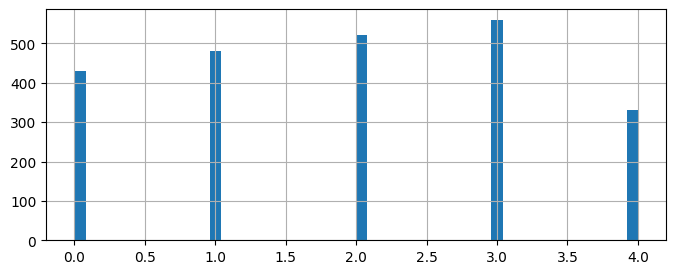

In [6]:
data = df_selected[lab_studied]
data.hist(figsize=(8, 3),bins=50,)
print(data.value_counts().sort_index())

<AxesSubplot: >

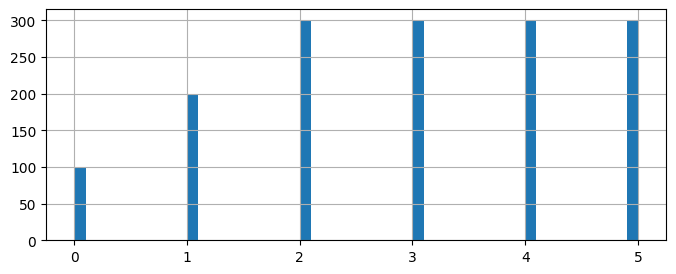

In [84]:
#TomekLinks#RandomUnderSampler
df_usamp=balance.class_undersampler(df_in=df_selected,str_label=lab_studied,str_method="RandomUnderSampler",dict_strat={0:34,1:82,2:300,3:300,4:300,5:151})
df_usamp=balance.class_oversampler(df_in=df_usamp,str_label=lab_studied,str_method="SMOTE",dict_strat={0:100,1:200,2:300,3:300,4:300,5:300})
#df_usamp.info()
data = df_usamp[lab_studied]
data.hist(figsize=(8, 3),bins=50,)


split dataframe into X,y

In [7]:
#df_selected=df_usamp  # if df_select has been under sampled before

df_x_train, col_y_train = sm.split_df_x_y(
    df_in=df_selected, list_features=list_feat, str_label=lab_studied, drop_na=True)
df_x_valid, col_y_valid = sm.split_df_x_y(
    df_in=df_valid, list_features=list_feat, str_label=lab_studied, drop_na=True)
print(f"nb rows train : {df_x_train.shape[0]} nb rows valid : {df_x_valid.shape[0]}")



nb rows train : 2323 nb rows valid : 513


Analysis of train set, heatmap correlation 

In [ ]:
corr_train = df_x_train.corr()
fig, ax = plt.subplots(figsize=(6, 6))
corr_train.replace(1,0,inplace=True)
#corr_train=corr_train.applymap(lambda x : None if x< 0.9 and x>-0.9 else x)
corr_train.dropna(axis=0,how='all',inplace=True)
corr_train.dropna(axis=1,how='all',inplace=True)
sns.heatmap(corr_train, annot=False, cmap='coolwarm', vmin=-1, vmax=1, ax=ax)


Variance Inflation Factor

In [ ]:
df_x_train_VIF = sma.add_constant(df_x_train)
vif = pd.DataFrame()
vif["feature"]=df_x_train_VIF.columns
vif["VIF"]= [smo.variance_inflation_factor(df_x_train_VIF.values, i) for i in range(df_x_train_VIF.shape[1])]
print(vif)


Feature analysis with Boruta

In [ ]:
rf_bo = RandomForestClassifier(n_estimators=100, n_jobs=-1)
boruta_selector = BorutaPy(rf_bo, n_estimators='auto',
                           verbose=1, random_state=int(rnd_key))
boruta_selector.fit(df_x_train.values, col_y_train.values)
selected_features = df_x_train.columns[boruta_selector.support_]
print(selected_features)


In [43]:
print(f"nb rows train : {df_x_train.shape[0]} nb rows valid : {df_x_valid.shape[0]}")

nb rows train : 2323 nb rows valid : 513


Hyperparameter tuning for Random Forest with  search CV

In [51]:

col_y_train_int = col_y_train.to_numpy().astype(int)

scoring = {
    'accuracy': metrics.make_scorer(metrics.accuracy_score),
    'precision_weighted': metrics.make_scorer(metrics.precision_score, average='weighted'),
    'recall_weighted': metrics.make_scorer(metrics.recall_score, average='weighted'),
    'f1_weighted': metrics.make_scorer(metrics.f1_score, average='weighted')
}

time_split = TimeSeriesSplit(n_splits=5)

# np.linspace(0.1, 0.5, 5, endpoint=True) # [0,0.01,0.02,0.03,0.04,0.05,0.06,0.075,0.1,0.12,0.15,0.2,0.25,0.3,0.4,0.5]
grid = {
    # number of trees in the foreset
    'n_estimators': np.linspace(50, 150,3, endpoint=True,dtype=int),
    # max number of features considered for splitting a node
    'max_features': ['sqrt'],
    # max number of levels in each decision tree
    'max_depth': np.linspace(4, 6, 3, endpoint=True,dtype=int),
    # min number of data points placed in a node before the node is split
    'min_samples_split': [0.075,0.1,0.125,0.15,0.2,0.25,0.3],
    # min number of data points allowed in a leaf node
    'min_samples_leaf': [0.1,0.15,0.2,0.25],# max 0.3
    # min weighted fraction of the sum total of weights
    'min_weight_fraction_leaf':[0.01,0.03,0.05,0.075,0.1,0.12,0.15,0.2,0.25,0.3],
    #min impurity decrease A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
    #'min_impurity_decrease':[0,0.01],
    'class_weight':['balanced']#[None,'balanced']
    }

rf = RandomForestClassifier()

rf_fitted = modmgr.search_cv_fit_report(estimator=rf, params=grid,cv=time_split,
                                        x_train=df_x_train, y_train=col_y_train, random_state=int(rnd_key),
                                          n_iter=1000, n_top=10, method="grid", scoring=metrics.make_scorer(metrics.f1_score, average='weighted'))

# mean_test_precision_weighted = rf_fitted.cv_results_['mean_test_precision_weighted']
# params=rf_fitted.cv_results_['params']

# ranked=np.argsort(-mean_test_precision_weighted)

# for rank,score_idx in enumerate(ranked):
#     if rank<20:
#         params_str = ', '.join(f"{param}: {value}" for param, value in params[score_idx].items())
#         print(f"Rank {rank+1}: mean_test_precision_weighted {mean_test_precision_weighted[score_idx]:.4f}, Parameters: {params_str}")

Fitting 5 folds for each of 2520 candidates, totalling 12600 fits
Accuracy train (make_scorer(f1_score, average=weighted)) :0.25340540605816814
Model with rank: 1
Mean validation score: 0.24343080137395026 (std: 0.015862144069321824)
Parameters: {'class_weight': 'balanced', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 0.2, 'min_samples_split': 0.1, 'min_weight_fraction_leaf': 0.25, 'n_estimators': 50}

Model with rank: 2
Mean validation score: 0.2419551270102051 (std: 0.02744746112225487)
Parameters: {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 0.25, 'min_samples_split': 0.1, 'min_weight_fraction_leaf': 0.2, 'n_estimators': 50}

Model with rank: 3
Mean validation score: 0.24041947680347237 (std: 0.025513997065846658)
Parameters: {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 0.2, 'min_samples_split': 0.2, 'min_weight_fraction_leaf': 0.3, 'n_estimators': 50}

Model with rank: 4
Mean vali

In [ ]:
modmgr.report_best_scores(rf_fitted.cv_results_, 5)

check parameters and test with validation dataset and show feature importance

In [62]:
rand_frst_class = RandomForestClassifier(n_estimators=100,  criterion="gini",
                                         random_state=rnd_key, max_depth=5, min_samples_split=0.3,
                                           min_samples_leaf=0.2, min_weight_fraction_leaf=0.25,min_impurity_decrease=0.0,
                                         max_features="sqrt", class_weight='balanced', oob_score=True)
rand_frst_class.fit(df_x_train, col_y_train)

print(
    f"Random Forest class training score : {rand_frst_class.score(df_x_train, col_y_train)} OOB : {rand_frst_class.oob_score_}")

y_pred_valid = rand_frst_class.predict(df_x_valid)
print(
    f"Random Forest class valid score:{rand_frst_class.score(df_x_valid,col_y_valid)} ")

feat_imp = rand_frst_class.feature_importances_
std_feat_imp = np.std(
    [tree.feature_importances_ for tree in rand_frst_class.estimators_], axis=0)
pd.Series(feat_imp, index=df_x_train.columns).sort_values(ascending=False)


Random Forest class training score : 0.32371932845458457 OOB : 0.30736117089969867
Random Forest class valid score:0.24561403508771928 


pos_sma200          0.217147
pos_bot_200         0.210528
pos_sma50_200       0.119300
pos_top_200         0.096279
pos_sma20_50        0.060623
pos_top50           0.060301
sma20_rsi14         0.058748
aroon14_up          0.044401
pos_top20           0.034827
pos_stdev20_sma5    0.029558
stdev20_sma20       0.023743
pos_bot20           0.022187
rsi14               0.007631
ret_5d              0.005085
pos_bot50           0.004996
macd_dif            0.004646
ret_1d              0.000000
pos_rsi14_sma5      0.000000
pos_rsi14_sma20     0.000000
dtype: float64

save model

In [63]:
ext_pkl = ".pkl"
rf_suffix = "_rf_class_v50" #v1=raw v2=with resample v3=with balanced v4=samp and balanced VX1+new hyper V50 balanced, new categ timesplit
joblib.dump(rand_frst_class, PATH_MODEL+symb+"_"+lab_studied+rf_suffix+ext_pkl)

['../../../Data/Models/CW8_lab_perf_21d_rf_class_v50.pkl']

In [ ]:
ext_pkl = ".pkl"
rf_check=joblib.load(PATH_MODEL+symb+"_"+lab_studied+"_rf_class_v1"+ext_pkl)
print(rf_check.get_params())
print(
    f"Random Forest class training score : {rand_frst_class.score(df_x_train, col_y_train)} OOB : {rand_frst_class.oob_score_}")
print(
    f"Random Forest class validation  score:{rf_check.score(df_x_valid,col_y_valid)}")
feat_imp = rf_check.feature_importances_
pd.Series(feat_imp, index=df_x_train.columns).sort_values(ascending=False)

Same thing with XGBoost
Hyperparameter tuning for XGBoost with search CV

In [167]:
col_y_train_int = col_y_train.to_numpy().astype(int)

scoring = {
    'accuracy': metrics.make_scorer(metrics.accuracy_score),
    'precision_weighted': metrics.make_scorer(metrics.precision_score, average='weighted'),
    'recall_weighted': metrics.make_scorer(metrics.recall_score, average='weighted'),
    'f1_weighted': metrics.make_scorer(metrics.f1_score, average='weighted')
}

# Set class weights
class_weights = {0: 1, 1: 10}  # Class 0: 1, Class 1: 10

# Set "scale_pos_weight" based on class balance
pos_weight = sum(class_weights.values()) / sum(class_weights.keys())

grid = {
    # default 1 subsample ratio of columns when constructing each tree
    "colsample_bytree": [x for x in np.linspace(0.5, 1.0, num=6, endpoint=True)],
    "colsample_bylevel": [x for x in np.linspace(0.5, 1.0, num=6, endpoint=True)],
    "colsample_bynode": [x for x in np.linspace(0.5, 1.0, num=6, endpoint=True)],
    # default 0 minimum loss reduction to make a further patition on a leaf
    "gamma": [x for x in np.linspace(0, 0.1, num=3, endpoint=True)],
    # [x for x in np.linspace(0.01, 0.3, num=8, endpoint=True)],  # default 0.1
    "learning_rate": [0.01, 0.02, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    # default 6 max depth of the tree
    "max_depth": [int(x) for x in np.linspace(2, 8, num=7, endpoint=True, dtype=int)],
    # default 100
    "n_estimators": [int(x) for x in np.linspace(start=50, stop=250, num=5, endpoint=True, dtype=int)],
    # default 1 subsample ratio of the training instances
    # [x for x in np.linspace(0.6, 1.0, num=3, endpoint=True)],
    "subsample": [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0],
    # default 1 minimum sum of instance weight needed in a child
    "min_child_weight": [x for x in np.linspace(0.5, 3, num=6, endpoint=True)],
    # default 0 Maximum delta step we allow each leaf output to be.
    "max_delta_step": [0, 1, 2, 3],
    # default 1 L2 regularization term on weights. Increasing this value will make model more conservative.
    #"lambda": [0.5, 1, 1.5, 2],
    # default 0 L1 regularization term on weights. Increasing this value will make model more conservative.
    #"alpha": [0, 0.25, 0.5, 0.75, 1, 1.5, 2]

}

xgb_class = xgb.XGBClassifier(objective='multi:softmax', num_class=6)
#2h pour 1000 cas !!
xgb_fitted = modmgr.search_cv_fit_report(estimator=xgb_class, params=grid,
                                         x_train=df_x_train, y_train=col_y_train_int, random_state=int(rnd_key),
                                           n_iter=5, n_top=10, method='random', scoring=scoring, refit='precision_weighted')

mean_test_precision_weighted = xgb_fitted.cv_results_['mean_test_precision_weighted']
params=xgb_fitted.cv_results_['params']

ranked=np.argsort(-mean_test_precision_weighted)

for rank,score_idx in enumerate(ranked):
    if rank<20:
        params_str = ', '.join(f"{param}: {value}" for param, value in params[score_idx].items())
        print(f"Rank {rank+1}: mean_test_precision_weighted {mean_test_precision_weighted[score_idx]:.4f}, Parameters: {params_str}")


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy train ({'accuracy': make_scorer(accuracy_score), 'precision_weighted': make_scorer(precision_score, average=weighted), 'recall_weighted': make_scorer(recall_score, average=weighted), 'f1_weighted': make_scorer(f1_score, average=weighted)}) :1.0
Rank 1: mean_test_precision_weighted 0.7129, Parameters: subsample: 0.8, n_estimators: 150, min_child_weight: 1.5, max_depth: 7, max_delta_step: 1, learning_rate: 0.3, lambda: 2, gamma: 0.0, colsample_bytree: 0.8, colsample_bynode: 0.5, colsample_bylevel: 0.7, alpha: 1.5
Rank 2: mean_test_precision_weighted 0.6854, Parameters: subsample: 0.7, n_estimators: 200, min_child_weight: 0.5, max_depth: 6, max_delta_step: 2, learning_rate: 0.02, lambda: 1.5, gamma: 0.0, colsample_bytree: 0.5, colsample_bynode: 0.8, colsample_bylevel: 1.0, alpha: 0.25
Rank 3: mean_test_precision_weighted 0.6728, Parameters: subsample: 0.4, n_estimators: 250, min_child_weight: 2.0, max_depth: 7, max_delta

Accuracy XGBoost classifier Training score : 0.654326302195437
Accuracy XGBoost classifier Validation score :0.12085769980506822


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

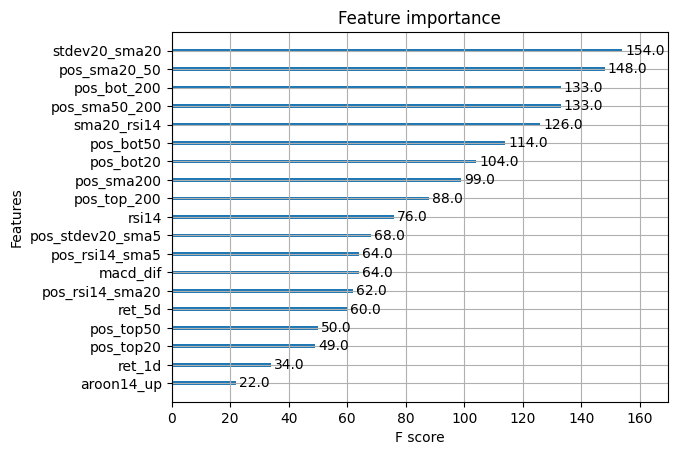

In [8]:
params={'subsample': 0.6, 'n_estimators': 50, 'min_child_weight': 0.5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.15, 'colsample_bytree': 0.5};

xgb_class = xgb.XGBClassifier(random_state=int(rnd_key),
                           learning_rate=params['learning_rate'], subsample=params['subsample'], gamma=params['gamma'],
                           colsample_bytree=params['colsample_bytree'],#colsample_bynode= 0.5, colsample_bylevel= 0.5,
                            max_depth=params['max_depth'], n_estimators=params['n_estimators'], min_child_weight=params['min_child_weight'], verbosity=1)

xgb_class.fit(df_x_train, col_y_train)

print(f"Accuracy XGBoost classifier Training score : {xgb_class.score(df_x_train, col_y_train)}")

#y_pred_valid = xgb_reg.predict(df_x_valid)

print(
    f"Accuracy XGBoost classifier Validation score :{xgb_class.score(df_x_valid,col_y_valid)}")

# print(xgb_reg.feature_importances_)
xgb.plot_importance(xgb_class)


In [9]:
ext_pkl = ".pkl"
xgb_suffix = "_xgb_class_v51"
joblib.dump(xgb_class, PATH_MODEL+symb+"_"+lab_studied+xgb_suffix+ext_pkl)


['../../../Data/Models/CW8_lab_perf_21d_xgb_class_v51.pkl']

Same thing with Ridge regression 
Hyperparameter tuning for Logistic Regression with random search CV

In [ ]:
grid = {
    "solver": ["svd", "cholesky", "lsqr", "sag"],
    "alpha": [x for x in np.logspace(1e-5, 100, 20)],
    "fit_intercept": [True, False],
    "normalize": [True, False]
}
lin_reg = Ridge()

lin_fitted = modmgr.search_cv_fit_report(estimator=lin_reg, params=grid,
                                            x_train=df_x_train, y_train=col_y_train, random_state=int(rnd_key), n_iter=100, n_top=5)


In [ ]:


params = {
    "solver": "cholesky",
    "normalize": True,
    "fit_intercept": True,
    "alpha": 1
}

lin_reg = Ridge(random_state=int(rnd_key),
                solver=params['solver'], normalize=params['normalize'], fit_intercept=params['fit_intercept'],
                alpha=params['alpha'])

lin_reg.fit(df_x_train, col_y_train)

print(f"Training score : {lin_reg.score(df_x_train, col_y_train)}")

print(
    f"Accuracy Ridge regressor Validation:{lin_reg.score(df_x_valid,col_y_valid)}")

print(lin_reg.coef_)


plt.bar(df_x_train.columns, lin_reg.coef_)
plt.xticks(range(len(df_x_train.columns)), df_x_train.columns, rotation=90)
plt.ylabel('Coefficient')
plt.title('Ridge features importance')
plt.show()


In [43]:
ext_pkl = ".pkl"
ridge_suffix = "_ridge_reg_v2"
joblib.dump(lin_reg, PATH_MODEL+symb+"_"+lab_studied+ridge_suffix+ext_pkl)

['../../../Data/Models/CW8_lab_perf_62d_ridge_reg_v2.pkl']

Generate scores values  for the dataset and save in csv

In [10]:
list_rf=["_xgb_class_v51"]#["_rf_class_v1","_rf_class_v2","_rf_class_v3","_rf_class_v4","_rf_class_v11","_rf_class_v21","_rf_class_v31","_rf_class_v41"]
list_predict=[]
algo_studied = "RANDOM_FOREST_CLASS"

df_prep = indic.drop_indicators_not_selected(
    con=con, df_in=df_class, dts_name=dts_name, symbol=symb, label=lab_studied, algo=algo_studied)
df_predict = indic.drop_indicators_by_type(
    con=con, df_in=df_prep, dts_name=dts_name, symbol=symb, ind_type=2)
df_predict.dropna(inplace=True)
X_cols_class = df_predict.columns

for name in list_rf:
    rf_check = joblib.load(PATH_MODEL+symb+"_"+lab_studied+name+ext_pkl)
    col='predict'+name
    list_predict.append(col)
    df_predict[col] = rf_check.predict(df_predict[X_cols_class])

df_prep = df_prep.join(
    df_predict[list_predict], how="left")
df_prep.dropna(inplace=True)
df_prep.round(5).to_csv(
    PATH_RES+dts_name+"_"+lab_studied+"_predict_class_test_TS.zip", sep=",")


In [ ]:
rf_check = joblib.load(PATH_MODEL+symb+"_"+lab_studied+"_rf_class_v1"+ext_pkl)
# xgb_check = joblib.load(PATH_MODEL+symb+"_"+lab_studied+"_xgb_reg_v2"+ext_pkl)
# ridge_check = joblib.load(
#     PATH_MODEL+symb+"_"+lab_studied+"_ridge_reg_v2"+ext_pkl)

# RF XGB and Ridge use the same features actually
algo_studied = "RANDOM_FOREST_CLASS"
df_prep = indic.drop_indicators_not_selected(
    con=con, df_in=df, dts_name=dts_name, symbol=symb, label=lab_studied, algo=algo_studied)
df_predict = indic.drop_indicators_by_type(
    con=con, df_in=df_prep, dts_name=dts_name, symbol=symb, ind_type=2)
df_predict.dropna(inplace=True)
X_cols_reg = df_predict.columns

df_predict['predict_rf'] = rf_check.predict(df_predict[X_cols_reg])
df_predict['predict_xgb'] = xgb_check.predict(df_predict[X_cols_reg])
df_predict['predict_ridge'] = ridge_check.predict(df_predict[X_cols_reg])
print(type(df_predict))
# if yeo johnson transform !!!!!
pt = balance.load_transformer(
    filename=PATH_MODEL+symb+"_PT_"+lab_studied+".pkl")
df_predict = balance.yeo_johnson_transform_inverse_col(
    df_in=df_predict, str_col='predict_rf', pt=pt)
df_predict = balance.yeo_johnson_transform_inverse_col(
    df_in=df_predict, str_col='predict_xgb', pt=pt)
df_predict = balance.yeo_johnson_transform_inverse_col(
    df_in=df_predict, str_col='predict_ridge', pt=pt)
df_predict['predict_rf']=df_predict['predict_rf']/5.0
df_predict['predict_xgb']=df_predict['predict_xgb']/5.0
df_predict['predict_ridge']=df_predict['predict_ridge']/5.0
# END if yeo johnson transform

df_predict['predict_avg'] = (
    df_predict['predict_rf']+df_predict['predict_xgb']+df_predict['predict_ridge'])/3.0

df_prep = df_prep.join(
    df_predict[['predict_rf', 'predict_xgb', 'predict_ridge', 'predict_avg']], how="left")
df_prep.dropna(inplace=True)
df_prep.round(5).to_csv(
    PATH_DATA+dts_name+"_"+lab_studied+"_predict_V2.zip", sep=",")


<class 'pandas.core.frame.DataFrame'>


In [ ]:
df_prep.describe()

In [ ]:
df_can = maria.get_candles_to_df(con=con, symbol=symb, only_close=False)
df_can.sort_index(inplace=True)
df_can.describe()

In [ ]:
df_bt=sm.join_dataframes_backtest(df_candle=df_can,df_score=df_prep,str_col_score='predict_ridge')
df_bt.describe(include='all')
df_bt.round(5).to_csv(
     "../../../Data/backtest/"+dts_name+"_"+lab_studied+"_predict_BT.zip", sep=",")